In [2]:
#1: Carregando o modelo YOLOv10-B
# Este código carrega o modelo YOLOv10-B a partir do caminho especificado. Ele importa as bibliotecas necessárias para o carregamento, incluindo classes de convolução e normalização para o YOLOv10. 
# Se o modelo for carregado com sucesso, a instância do modelo YOLOv10-B é criada e uma mensagem de sucesso é exibida. Caso contrário, é gerado um erro e o modelo não é carregado.
import torch
from ultralytics import YOLO
from torch.nn.modules.conv import Conv2d  # Adicionar Conv2d
from torch.nn.modules.batchnorm import BatchNorm2d  # Adicionar BatchNorm2d
from torch.nn.modules.activation import SiLU  # Adicionar SiLU
from torch.nn.modules.container import ModuleList  # Adicionar ModuleList
from ultralytics.nn.modules.conv import Conv  # Adicionar Conv (YOLO)
from ultralytics.nn.modules.block import C2f, Bottleneck  # Adicionar C2f e Bottleneck (YOLO)

# Caminho para o modelo YOLOv10-B
model_path = "/home/thalles.fontainha/yolov10/yolov10b.pt"

# Carregar o modelo YOLO
try:
    model = YOLO(model_path)  # Criar a instância do YOLOv10
    print("Modelo YOLOv10-B carregado com sucesso!")

except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    model = None  # Garante que o modelo não seja usado se o carregamento falhar

Modelo YOLOv10-B carregado com sucesso!


In [3]:
#2: Carregar os dados (.npy) e dividi-los
import numpy as np
from sklearn.model_selection import train_test_split

# Caminhos dos arquivos .npy
abnormal_path = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/abnormal-3DESS-128-64.npy"
normal_path = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/normal-3DESS-128-64.npy"

# Carregar os dados usando mmap para evitar estouro de memória
abnormal_data = np.load(abnormal_path, mmap_mode="r")
normal_data = np.load(normal_path, mmap_mode="r")

# Criar rótulos (1 para abnormal, 0 para normal)
abnormal_labels = np.ones(len(abnormal_data))
normal_labels = np.zeros(len(normal_data))

# Concatenar dados e rótulos
X = np.concatenate([abnormal_data, normal_data], axis=0)
y = np.concatenate([abnormal_labels, normal_labels], axis=0)

# Dividir em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dados carregados e divididos!")
print(f"Tamanho do treino: {len(X_train)} | Tamanho da validação: {len(X_val)}")

Dados carregados e divididos!
Tamanho do treino: 2380 | Tamanho da validação: 596


In [4]:
#3: Criar um Dataset PyTorch para carregamento eficiente
from torch.utils.data import Dataset, DataLoader

class MRI3DDataset(Dataset):
    """Dataset personalizado para carregar os dados de imagens 3D"""
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)  # Converter para tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label

# Criar datasets
train_dataset = MRI3DDataset(X_train, y_train)
val_dataset = MRI3DDataset(X_val, y_val)

# Criar DataLoaders para batches eficientes
batch_size = 32  # Ajuste conforme necessário
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Datasets configurados! Pronto para o treinamento.")

Datasets configurados! Pronto para o treinamento.


In [7]:
# 4: Código otimizado para carregar o modelo YOLOv10 sem erros no PyTorch 2.0.1
import torch
from ultralytics import YOLO

# Caminho para o modelo YOLOv10-B
model_path = "/home/thalles.fontainha/yolov10/yolov10b.pt"

try:
    # Criar a instância do modelo YOLOv10
    model = YOLO(model_path)
    print("Modelo YOLOv10-B criado com sucesso!")

    # Configurar para múltiplas GPUs, se disponíveis
    num_gpus = torch.cuda.device_count()
    if num_gpus >= 2:
        model = torch.nn.DataParallel(model)  # Habilitar múltiplas GPUs
        print(f"Modelo configurado para usar {num_gpus} GPUs.")
    else:
        print("Modelo configurado para usar 1 GPU.")

except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    model = None  # Evita o uso de um modelo inválido

Modelo YOLOv10-B criado com sucesso!
Modelo configurado para usar 2 GPUs.


In [9]:
#5 (Configuração do Treinamento)

# Configurar perda, otimizador e métricas
import torch.optim as optim
import torch.nn as nn

if model is not None:  # Evita erro caso o modelo não tenha carregado
    # Função de perda (CrossEntropy para classificação)
    criterion = nn.CrossEntropyLoss()

    # Otimizador (Adam)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Configuração do treinamento concluída!")
else:
    print("Não foi possível configurar o treinamento porque o modelo não foi carregado.")

Configuração do treinamento concluída!


In [14]:
# Verificar quais parâmetros train() aceita
print(model.train.__doc__)


Sets the module in training mode.

        This has any effect only on certain modules. See documentations of
        particular modules for details of their behaviors in training/evaluation
        mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
        etc.

        Args:
            mode (bool): whether to set training mode (``True``) or evaluation
                         mode (``False``). Default: ``True``.

        Returns:
            Module: self
        


In [15]:
# Verificar se o modelo está carregado corretamente
print(type(model))  # Deve imprimir algo como <class 'ultralytics.nn.tasks.YOLO'>


<class 'torch.nn.parallel.data_parallel.DataParallel'>


In [16]:
model = YOLO("/home/thalles.fontainha/yolov10/yolov10b.pt")  # Recarregar corretamente


In [17]:
# Listar os métodos do objeto model
print(dir(model))


['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_check_is_pytorch_model', '_decode_arg', '_encode_arg', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_from_pretrained', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_hub_session', '_get_name', '_hub_mixin_coders', '_hub_mixin_config', '_hub_mixin_config', '_hub_mixin_info', '_hub_mixin_init_parameters', '_hub_mixin_inject_config', '_hub_mixin_jsonable_custom_types', '_hub_mixin_jsonable_default_values', '_is_full_backward_h

In [18]:
print(model.train.__doc__)



        Trains the model using the specified dataset and training configuration.

        This method facilitates model training with a range of customizable settings and configurations. It supports
        training with a custom trainer or the default training approach defined in the method. The method handles
        different scenarios, such as resuming training from a checkpoint, integrating with Ultralytics HUB, and
        updating model and configuration after training.

        When using Ultralytics HUB, if the session already has a loaded model, the method prioritizes HUB training
        arguments and issues a warning if local arguments are provided. It checks for pip updates and combines default
        configurations, method-specific defaults, and user-provided arguments to configure the training process. After
        training, it updates the model and its configurations, and optionally attaches metrics.

        Args:
            trainer (BaseTrainer, optional): An inst

In [19]:
!pip show ultralytics


Name: ultralytics
Version: 8.1.34
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: 
Author: Glenn Jocher, Ayush Chaurasia, Jing Qiu
Author-email: 
License: AGPL-3.0
Location: /home/thalles.fontainha/jupyter_env_310/lib/python3.10/site-packages
Editable project location: /home/thalles.fontainha/yolov10
Requires: matplotlib, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 


In [21]:
#6 - Treinamento do Modelo YOLOv10 com Múltiplas GPUs
# Configuração do Treinamento
if model:
    yaml_path = "/home/thalles.fontainha/yolov10/mri3ddess.yaml"  # Configuração do dataset

    # Ajustar os argumentos para o treinamento
    train_args = {
        "data": yaml_path,  # Caminho do dataset
        "epochs": 10,  # Número de épocas
        "batch": 8,  # Corrigir para 'batch' em vez de 'batch_size'
        "imgsz": 640,  # Tamanho da imagem
        "workers": 4,  # Número de threads para carregamento dos dados
        "device": "0",  # Usar a primeira GPU
        "optimizer": "Adam",  # Escolher otimizador
        "lr0": 0.01,  # Taxa de aprendizado inicial
        "momentum": 0.937,  # Momentum do otimizador
        "amp": True,  # Mixed Precision
    }

    print("Iniciando o treinamento...")

    try:
        # Chamar o método de treinamento
        metrics = model.train(**train_args)
        print("Treinamento concluído com sucesso!")
        print("Métricas do treinamento:", metrics)
    except Exception as e:
        print(f"Erro durante o treinamento: {e}")
else:
    print("Modelo não foi carregado corretamente. Treinamento abortado.")

Iniciando o treinamento...
New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.16 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11009MiB)
engine/trainer: task=detect, mode=train, model=/home/thalles.fontainha/yolov10/yolov10b.pt, data=/home/thalles.fontainha/yolov10/mri3ddess.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=0, workers=4, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visuali

2025-02-03 10:18:15.455167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738588695.589379   59641 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738588695.641315   59641 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  4   1444864  ultralytics.nn.modules.block.C2f             [256, 256, 4, True]           
  5                  -1  1    137728  ultralytics.nn.modules.block.SCDown          [256, 512, 3, 2]              
  6                  -1  4   5773312  ultralytics.nn.modules.block.C2f             [512, 512, 4, True]           
  7                  -1  1    268800  ultralytics

train: Scanning /home/thalles.fontainha/dataset/OAI-MRI-3DDESS/train/Abnormal.cache... 0 images, 4760 backgrounds, 0 corrupt: 100%|██████████| 4760/4760 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /home/thalles.fontainha/dataset/OAI-MRI-3DDESS/train/Abnormal.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.



val: Scanning /home/thalles.fontainha/dataset/OAI-MRI-3DDESS/val/Abnormal.cache... 0 images, 1192 backgrounds, 0 corrupt: 100%|██████████| 1192/1192 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /home/thalles.fontainha/dataset/OAI-MRI-3DDESS/val/Abnormal.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


Plotting labels to /home/thalles.fontainha/runs/detect/train23/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 135 weight(decay=0.0), 148 weight(decay=0.0005), 147 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/thalles.fontainha/runs/detect/train23
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.55it/s]01:36<00:00,  6.15it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.56it/s]01:34<00:00,  6.33it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.57it/s]01:32<00:00,  6.43it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.58it/s]01:32<00:00,  6.46it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.59it/s]01:32<00:00,  6.46it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.60it/s]01:32<00:00,  6.45it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.58it/s]01:32<00:00,  6.46it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.58it/s]01:32<00:00,  6.44it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.57it/s]01:32<00:00,  6.46it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:16<00:00,  4.57it/s]01:32<00:00,  6.46it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



10 epochs completed in 0.314 hours.
Optimizer stripped from /home/thalles.fontainha/runs/detect/train23/weights/last.pt, 41.4MB
Optimizer stripped from /home/thalles.fontainha/runs/detect/train23/weights/best.pt, 41.4MB

Validating /home/thalles.fontainha/runs/detect/train23/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.16 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11009MiB)
YOLOv10b summary (fused): 383 layers, 20414236 parameters, 0 gradients, 97.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:15<00:00,  4.76it/s]

                   all       1192          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 0.4ms preprocess, 12.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /home/thalles.fontainha/runs/detect/train23
Treinamento concluído com sucesso!
Métricas do treinamento: Erro durante o treinamento: 'DetMetrics' object has no attribute 'curves_results'. See valid attributes below.

    This class is a utility class for computing detection metrics such as precision, recall, and mean average precision
    (mAP) of an object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (tuple of str): A tuple of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A

In [5]:
#7 Importar bibliotecas necessárias
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Garantir que o modelo foi carregado corretamente
if 'model' not in locals() or model is None:
    from ultralytics import YOLO
    model_path = "/home/thalles.fontainha/yolov10/yolov10b.pt"
    model = YOLO(model_path)
    print(f"Modelo carregado do caminho: {model_path}")

# Colocar o modelo em modo de avaliação
model.eval()

# Verificar se o dataset de validação está disponível
if 'val_loader' not in locals():
    raise NameError("Erro: 'val_loader' não está definido. Configure corretamente os dados de validação.")

print("Iniciando avaliação do modelo...")

# Inicializar listas para armazenar predições e rótulos verdadeiros
all_preds = []
all_labels = []

# Desativar gradientes para economizar memória e acelerar a avaliação
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Pegamos as predições de maior probabilidade
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular métricas de avaliação
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")

# Exibir apenas as métricas essenciais
print("\n==== Resultados da Avaliação ====")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Analisar métricas do treinamento, se disponíveis
if 'metrics' in locals():
    print("\n==== Métricas do Treinamento ====")
    try:
        train_results = metrics.results_dict()  # Obter dicionário de métricas
        print(f"Train Loss: {train_results.get('train_loss', 'N/A')}")
        print(f"Val Loss: {train_results.get('val_loss', 'N/A')}")
        print(f"mAP@50: {train_results.get('mAP50', 'N/A')}")
        print(f"mAP@50-95: {train_results.get('mAP50-95', 'N/A')}")
        print(f"Precision: {train_results.get('precision', 'N/A')}")
        print(f"Recall: {train_results.get('recall', 'N/A')}")

        # Analisar overfitting (se a loss de treino for muito menor que a de validação)
        train_loss = train_results.get("train_loss", np.nan)
        val_loss = train_results.get("val_loss", np.nan)

        if not np.isnan(train_loss) and not np.isnan(val_loss):
            if train_loss < (0.8 * val_loss):
                print("\n⚠️ Possível Overfitting: O loss de treino é muito menor que o de validação.")

    except Exception as e:
        print(f"Erro ao obter métricas do treinamento: {e}")
else:
    print("\n⚠️ Nenhuma métrica do treinamento encontrada.")


New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.16 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11009MiB)
engine/trainer: task=detect, mode=train, model=/home/thalles.fontainha/yolov10/yolov10b.pt, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train25, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None,



val: Scanning /home/thalles.fontainha/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]/s]

Plotting labels to /home/thalles.fontainha/runs/detect/train25/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 135 weight(decay=0.0), 148 weight(decay=0.0005), 147 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to /home/thalles.fontainha/runs/detect/train25
Starting training for 100 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]:00<00:00,  7.53it/s]

                   all          4         17      0.907       0.56      0.812      0.557



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]:00<00:00,  7.95it/s]

                   all          4         17      0.906       0.56      0.812      0.557



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]:00<00:00,  7.87it/s]

                   all          4         17      0.907      0.561      0.812      0.566



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]:00<00:00,  7.96it/s]

                   all          4         17      0.907      0.562       0.77      0.543



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]:00<00:00,  7.84it/s]

                   all          4         17      0.908      0.562      0.769      0.543



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]:00<00:00,  6.97it/s]

                   all          4         17       0.91      0.562      0.724      0.514



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]:00<00:00,  7.68it/s]

                   all          4         17       0.91      0.563      0.724      0.514



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]:00<00:00,  7.69it/s]

                   all          4         17      0.911      0.563      0.749      0.548



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]:00<00:00,  7.76it/s]

                   all          4         17      0.913      0.562      0.749       0.54



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]:00<00:00,  7.67it/s]

                   all          4         17      0.914      0.562      0.724      0.525



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]:00<00:00,  7.65it/s]

                   all          4         17      0.913       0.56      0.832      0.601



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]:00<00:00,  7.77it/s]

                   all          4         17      0.912      0.559      0.823      0.611



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]:00<00:00,  7.72it/s]

                   all          4         17      0.909      0.562      0.851      0.626



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]:00<00:00,  7.86it/s]

                   all          4         17      0.909      0.563       0.83      0.615



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]:00<00:00,  7.75it/s]

                   all          4         17      0.909      0.555      0.837      0.617



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]:00<00:00,  7.78it/s]

                   all          4         17      0.908      0.545      0.829      0.626



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]:00<00:00,  7.67it/s]

                   all          4         17      0.908      0.549       0.83      0.624



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]:00<00:00,  9.89it/s]

                   all          4         17      0.908      0.549       0.83      0.624



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]:00<00:00,  7.92it/s]

                   all          4         17      0.911      0.551      0.829      0.565



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.94it/s]:00<00:00,  9.84it/s]

                   all          4         17      0.911      0.551      0.829      0.565



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]:00<00:00,  7.83it/s]

                   all          4         17      0.911      0.553      0.829      0.574



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]:00<00:00,  9.66it/s]

                   all          4         17      0.911      0.553      0.829      0.574



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]:00<00:00,  7.91it/s]

                   all          4         17      0.906       0.55      0.834      0.576



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]:00<00:00,  9.71it/s]

                   all          4         17      0.906       0.55      0.834      0.576



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]:00<00:00,  7.71it/s]

                   all          4         17      0.856      0.573      0.752       0.52



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]:00<00:00,  9.63it/s]

                   all          4         17      0.856      0.573      0.752       0.52



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]:00<00:00,  7.78it/s]

                   all          4         17      0.888      0.575      0.749      0.509



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]:00<00:00,  9.62it/s]

                   all          4         17      0.888      0.575      0.749      0.509



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]:00<00:00,  7.83it/s]

                   all          4         17      0.897      0.549      0.749      0.507



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]:00<00:00,  9.83it/s]

                   all          4         17      0.897      0.549      0.749      0.507



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]:00<00:00,  7.85it/s]

                   all          4         17      0.794      0.612      0.804      0.522



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]:00<00:00,  9.87it/s]

                   all          4         17      0.794      0.612      0.804      0.522



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]:00<00:00,  7.83it/s]

                   all          4         17      0.887      0.568      0.831      0.506



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]:00<00:00,  9.52it/s]

                   all          4         17      0.887      0.568      0.831      0.506



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]:00<00:00,  7.88it/s]

                   all          4         17      0.785      0.597      0.846      0.504



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]:00<00:00,  9.85it/s]

                   all          4         17      0.785      0.597      0.846      0.504



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]:00<00:00,  7.85it/s]

                   all          4         17      0.891      0.562       0.78      0.475



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]:00<00:00,  9.52it/s]

                   all          4         17      0.891      0.562       0.78      0.475



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]:00<00:00,  7.82it/s]

                   all          4         17      0.887      0.565       0.78      0.458



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]:00<00:00,  8.79it/s]

                   all          4         17      0.887      0.565       0.78      0.458



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]:00<00:00,  7.98it/s]

                   all          4         17      0.794      0.615      0.736      0.445



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]:00<00:00,  9.84it/s]

                   all          4         17      0.794      0.615      0.736      0.445



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]:00<00:00,  7.80it/s]

                   all          4         17      0.795      0.614      0.714      0.443



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]:00<00:00,  9.77it/s]

                   all          4         17      0.795      0.614      0.714      0.443



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size




                Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]:00<00:00,  8.21it/s]

                   all          4         17      0.792      0.616      0.714      0.444

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]:00<00:00,  9.81it/s]

                   all          4         17      0.792      0.616      0.714      0.444



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]:00<00:00,  7.79it/s]

                   all          4         17       0.79      0.615      0.608      0.442



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]:00<00:00,  9.73it/s]

                   all          4         17       0.79      0.615      0.608      0.442



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]:00<00:00,  7.80it/s]

                   all          4         17      0.851       0.57      0.636      0.479



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]:00<00:00,  9.77it/s]

                   all          4         17      0.851       0.57      0.636      0.479



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]:00<00:00,  7.77it/s]

                   all          4         17      0.901       0.56      0.645      0.467



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]:00<00:00,  9.79it/s]

                   all          4         17      0.901       0.56      0.645      0.467



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]:00<00:00, 10.04it/s]

                   all          4         17      0.901       0.56      0.645      0.467



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]:00<00:00,  7.81it/s]

                   all          4         17      0.791      0.626      0.613      0.464



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]:00<00:00,  9.77it/s]

                   all          4         17      0.791      0.626      0.613      0.464



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]:00<00:00, 10.07it/s]

                   all          4         17      0.791      0.626      0.613      0.464



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]:00<00:00,  7.79it/s]

                   all          4         17      0.913      0.554       0.64      0.466



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]:00<00:00,  9.76it/s]

                   all          4         17      0.913      0.554       0.64      0.466



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]:00<00:00, 10.02it/s]

                   all          4         17      0.913      0.554       0.64      0.466



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]:00<00:00,  7.81it/s]

                   all          4         17      0.932      0.548      0.638      0.463



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]:00<00:00,  9.70it/s]

                   all          4         17      0.932      0.548      0.638      0.463



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]:00<00:00, 10.07it/s]

                   all          4         17      0.932      0.548      0.638      0.463



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]:00<00:00,  7.43it/s]

                   all          4         17      0.942      0.547      0.636      0.459



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]:00<00:00,  9.87it/s]

                   all          4         17      0.942      0.547      0.636      0.459



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]:00<00:00, 10.09it/s]

                   all          4         17      0.942      0.547      0.636      0.459



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]:00<00:00,  7.92it/s]

                   all          4         17       0.95      0.546      0.635      0.448



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]:00<00:00,  9.73it/s]

                   all          4         17       0.95      0.546      0.635      0.448



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]:00<00:00, 10.02it/s]

                   all          4         17       0.95      0.546      0.635      0.448



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]:00<00:00,  7.83it/s]

                   all          4         17      0.953      0.542      0.718      0.456



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]:00<00:00,  9.75it/s]

                   all          4         17      0.953      0.542      0.718      0.456



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]:00<00:00,  9.85it/s]

                   all          4         17      0.953      0.542      0.718      0.456



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]:00<00:00,  7.83it/s]

                   all          4         17      0.936      0.547      0.718      0.455



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]:00<00:00,  9.73it/s]

                   all          4         17      0.936      0.547      0.718      0.455



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]:00<00:00,  9.85it/s]

                   all          4         17      0.936      0.547      0.718      0.455



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]:00<00:00,  7.83it/s]

                   all          4         17      0.957       0.54      0.717      0.475



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]:00<00:00,  9.77it/s]

                   all          4         17      0.957       0.54      0.717      0.475



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]:00<00:00, 10.01it/s]

                   all          4         17      0.957       0.54      0.717      0.475



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]:00<00:00,  7.84it/s]

                   all          4         17      0.952      0.543      0.717      0.477



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]:00<00:00,  9.74it/s]

                   all          4         17      0.952      0.543      0.717      0.477



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]:00<00:00,  9.95it/s]

                   all          4         17      0.952      0.543      0.717      0.477



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]:00<00:00,  7.78it/s]

                   all          4         17      0.805      0.633      0.717      0.485



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.70it/s]:00<00:00,  9.76it/s]

                   all          4         17      0.805      0.633      0.717      0.485



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]:00<00:00, 10.00it/s]

                   all          4         17      0.805      0.633      0.717      0.485



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]:00<00:00,  7.88it/s]

                   all          4         17      0.913      0.569      0.717        0.5



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]:00<00:00,  9.68it/s]

                   all          4         17      0.913      0.569      0.717        0.5



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.72it/s]:00<00:00,  9.91it/s]

                   all          4         17      0.913      0.569      0.717        0.5



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]:00<00:00,  9.91it/s]

                   all          4         17      0.913      0.569      0.717        0.5



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]:00<00:00,  7.82it/s]

                   all          4         17      0.903       0.57      0.717      0.516



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.90it/s]:00<00:00,  9.67it/s]

                   all          4         17      0.903       0.57      0.717      0.516



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]:00<00:00, 10.07it/s]

                   all          4         17      0.903       0.57      0.717      0.516


Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]:00<00:00,  7.01it/s]

                   all          4         17      0.903       0.57      0.717      0.516



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]:00<00:00,  7.85it/s]

                   all          4         17      0.916      0.549      0.716       0.52



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]:00<00:00,  9.48it/s]

                   all          4         17      0.916      0.549      0.716       0.52



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]:00<00:00,  9.86it/s]

                   all          4         17      0.916      0.549      0.716       0.52



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]:00<00:00, 10.20it/s]

                   all          4         17      0.916      0.549      0.716       0.52



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]:00<00:00,  7.81it/s]

                   all          4         17      0.955      0.526      0.709      0.513



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]:00<00:00,  9.77it/s]

                   all          4         17      0.955      0.526      0.709      0.513



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]:00<00:00, 10.00it/s]

                   all          4         17      0.955      0.526      0.709      0.513



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]:00<00:00,  9.83it/s]

                   all          4         17      0.955      0.526      0.709      0.513



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]:00<00:00,  7.78it/s]

                   all          4         17      0.955      0.525      0.714      0.517



100 epochs completed in 0.047 hours.
Optimizer stripped from /home/thalles.fontainha/runs/detect/train25/weights/last.pt, 41.7MB
Optimizer stripped from /home/thalles.fontainha/runs/detect/train25/weights/best.pt, 41.7MB

Validating /home/thalles.fontainha/runs/detect/train25/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.16 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11009MiB)
YOLOv10b summary (fused): 383 layers, 20534512 parameters, 0 gradients, 98.6 GFLOPs



                Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]

                   all          4         17      0.909      0.562      0.851      0.626
                person          4         10          1      0.372      0.844      0.471
                   dog          4          1          1          0      0.995      0.796
                 horse          4          2      0.956          1      0.995      0.567
              elephant          4          2          1          0      0.284      0.134
              umbrella          4          1      0.758          1      0.995      0.995
          potted plant          4          1      0.741          1      0.995      0.796
Speed: 0.3ms preprocess, 13.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /home/thalles.fontainha/runs/detect/train25


NameError: Erro: 'val_loader' não está definido. Configure corretamente os dados de validação.

In [7]:
#8: Salvar o modelo treinado com nome único
import os
from datetime import datetime

# Verificar se o modelo foi treinado
if model:
    # Caminho do diretório onde os modelos serão salvos
    save_dir = "/home/thalles.fontainha/modelos"

    # Criar o diretório se não existir
    os.makedirs(save_dir, exist_ok=True)

    # Gerar nome único para o modelo
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_name = f"VGG16_treinado_{timestamp}.pth"

    # Caminho completo do arquivo a ser salvo
    save_path = os.path.join(save_dir, model_name)

    try:
        # Salvar o modelo
        torch.save(model.state_dict(), save_path)
        print(f"Modelo salvo com sucesso em: {save_path}")
    except Exception as e:
        print(f"Erro ao salvar o modelo: {e}")
else:
    print("Não há modelo treinado para salvar.")

Modelo salvo com sucesso em: /home/thalles.fontainha/modelos/VGG16_treinado_2025-02-03_11-30-22.pth


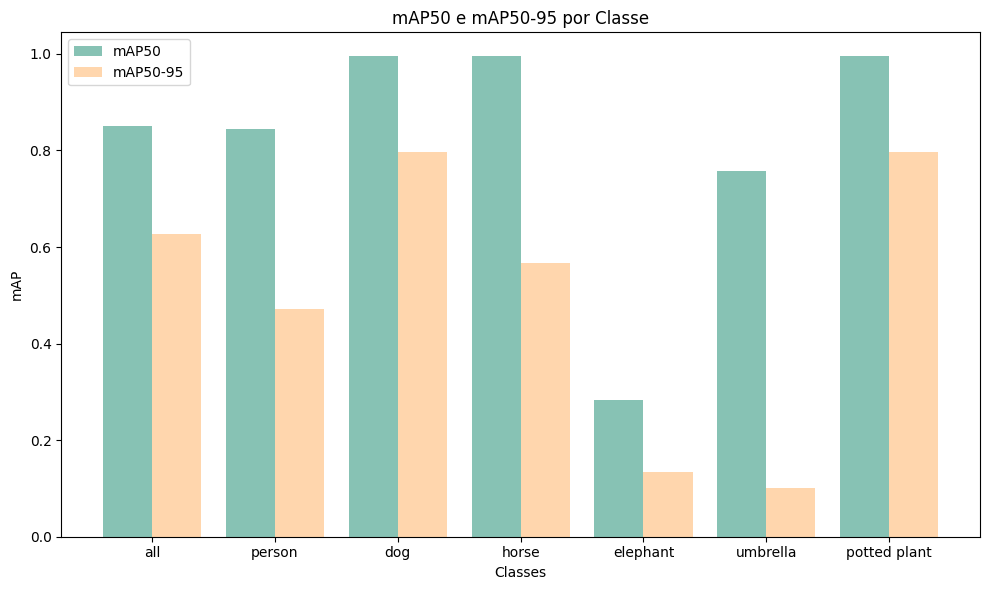

In [29]:
# Garantir que os gráficos apareçam no Jupyter Notebook
%matplotlib inline

import matplotlib.pyplot as plt

# Dados extraídos da imagem
classes = ["all", "person", "dog", "horse", "elephant", "umbrella", "potted plant"]
mAP50 = [0.851, 0.844, 0.995, 0.995, 0.284, 0.758, 0.995]
mAP50_95 = [0.626, 0.471, 0.796, 0.567, 0.134, 0.101, 0.796]

# Criar o gráfico
plt.figure(figsize=(10, 6))
bar_width = 0.4
x = range(len(classes))

# Barras para mAP50 e mAP50-95 com cores claras
plt.bar(x, mAP50, width=bar_width, label="mAP50", alpha=0.8, color="#69b3a2")  # Verde-água claro
plt.bar([p + bar_width for p in x], mAP50_95, width=bar_width, label="mAP50-95", alpha=0.8, color="#ffcc99")  # Laranja claro

# Configurações do gráfico
plt.xlabel("Classes")
plt.ylabel("mAP")
plt.title("mAP50 e mAP50-95 por Classe")
plt.xticks([p + bar_width / 2 for p in x], classes)
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()

Com base nos gráficos do treinamento do YOLOv10 no dataset MRI 3D DESS, é evidente que as classes do dataset COCO, como "person" e "dog", são muito diferentes das características anatômicas do joelho, que são o foco do MRI 3D DESS. O modelo, portanto, não está totalmente preparado para identificar estruturas específicas como cartilagem e ossos do joelho

In [23]:
import torch

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDA Disponível? {torch.cuda.is_available()}")
print(f"GPU Ativa: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Nenhuma GPU disponível'}")

PyTorch Version: 2.0.1+cu118
CUDA Version: 11.8
CUDA Disponível? True
GPU Ativa: NVIDIA GeForce RTX 2080 Ti


In [24]:
!nvidia-smi
!nvcc --version

Mon Feb  3 12:00:27 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| 30%   34C    P8               1W / 250W |   2152MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--